## Train SEVIRI baseline retrieval

In [71]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
data_path = Path(os.environ["TRAINING_DATA"])

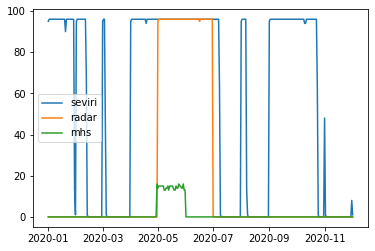

In [70]:
from cimr.data.training_data import plot_date_distribution
plot_date_distribution(data_path, ["seviri", "radar", "mhs"])

In [22]:
from cimr.data.training_data import CIMRDataset, CIMRSequenceDataset
from torch.utils.data import DataLoader

start_time = np.datetime64("2020-05-01T00:00:00")
end_time = np.datetime64("2020-06-28T00:00:00")
training_data = CIMRDataset(data_path,
                            start_time=start_time,
                            end_time=end_time,
                            window_size=128,
                            sequence_length=1,
                            sample_rate=1)
training_loader = DataLoader(training_data, num_workers=8, batch_size=8, shuffle=True)

start_time = np.datetime64("2020-06-28T00:00:00")
end_time = np.datetime64("2020-07-01T00:00:00")
validation_data = CIMRDataset(data_path,
                              start_time=start_time,
                              end_time=end_time,
                              window_size=128,
                              sequence_length=1)
validation_loader = DataLoader(validation_data, num_workers=4, batch_size=16, shuffle=True)

In [14]:
from cimr.models import CIMRSeviri, CIMRSeqSeviri
model = CIMRSeviri(n_stages=4, features=96, n_outputs=64)

In [11]:
import torch
from cimr.models import CIMRSmol
from quantnn.qrnn import QRNN

quantiles = np.linspace(0, 1, 66)[1:-1]
qrnn = QRNN(quantiles=quantiles, model=model)

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e16627820>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e16627820><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e16627820>  File "/home/simonpf/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e16627820>

Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/simonpf/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/home/simonpf/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
          File "/home/simonpf/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
self._shutdown_workers()self._shutdown_worke

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/simonpf/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/simonpf/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/simonpf/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/simonpf/src/cimr/cimr/data/training_data.py", line 786, in __getitem__
    xs = [self.rng.uniform(10, -10, 10) * np.ones((11,), + self.size)]
  File "_generator.pyx", line 946, in numpy.random._generator.Generator.uniform
  File "_common.pyx", line 595, in numpy.random._common.cont
  File "_common.pyx", line 404, in numpy.random._common.check_constraint
ValueError: high - low < 0


In [ ]:
n_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=n_epochs
)
qrnn.train(
    training_data=training_loader,
    validation_data=validation_loader,
    n_epochs=n_epochs,
    device="cuda",
    mask=-100,
    optimizer=optimizer,
    scheduler=scheduler
)
qrnn.save(cimr_path / models / "cimr_seviri.pckl")